# Segmenting and clustering neighbourhoods of Toronto

## Scraping the web for the neighboruhoods of Toronto
Data Source 1: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Data Source 2: http://cocl.us/Geospatial_data

Data Source 3: Foursquare API

In [1]:
import requests
import pandas as pd
import numpy as np
import scipy as sy
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt

### 1. Scraping the data source for dataset

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

html = requests.get(url).text
all_df = pd.read_html(html)
toronto_df = all_df[0]
toronto_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### 2. Removing any observations that do not have an assigned Borough

In [3]:
toronto_df.replace('Not assigned', np.nan, inplace=True)
toronto_df.dropna(subset=['Borough'], axis=0, inplace=True)
toronto_df.reset_index(drop=True)
toronto_df.shape

(103, 3)

### 3. Getting geolocation data based on postal code and merging the two dataframes

In [4]:
geo_data = pd.read_csv('http://cocl.us/Geospatial_data')
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
toronto_df = toronto_df.join(geo_data.set_index('Postal Code'), on='Postal Code')
toronto_df.reset_index(drop=True, inplace=True)
toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [6]:
print('The dataframe has {} boroughs and {} neighbourhoods.'.format(len(toronto_df['Borough'].unique()),toronto_df.shape[0]))

The dataframe has 10 boroughs and 103 neighbourhoods.


### 4. Creating basic map of Toronto

In [7]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_exp")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [8]:
map_toronto = folium.Map(location = [latitude, longitude], zoom_start=10)

for lat, lng, borough, neighbourhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
map_toronto

In [9]:
# The code was removed by Watson Studio for sharing.

### 5. Retrieving data related to venues in all the neighbourhoods, we'll be looking for at most 100 venues within a radius of 500 meters. 

This is done using Foursquare API.

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )
print(toronto_venues.shape)
toronto_venues.head()

Parkwoods


NameError: name 'CLIENT_ID' is not defined

In [ ]:
toronto_venues.groupby('Neighbourhood').count()

Above we can see the number of retrieved venues grouped by their neighbourhood. 

### 6. Looking at what are the most prominent categories in each neighbourhood

In [55]:
# one hot encoding
onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
onehot.shape

(2150, 273)

Before we start clustering, let's get an idea of what each neighbourhood has, so let's look at top 10 venues of each neighbourhood

In [178]:
venues_in_neighbourhood = onehot.groupby('Neighbourhood').mean().reset_index()
venues_in_neighbourhood.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
venues_in_neighbourhood.shape

(96, 273)

In [63]:
def return_most_common_venues(row, top):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top]

In [66]:
top = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(top):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = venues_in_neighbourhood['Neighbourhood']

for ind in np.arange(venues_in_neighbourhood.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_in_neighbourhood.iloc[ind, :], top)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Skating Rink,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Sandwich Place,Pharmacy,Pub,Gym,Airport Lounge,Dance Studio,Electronics Store,Eastern European Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Supermarket,Pizza Place,Deli / Bodega,Ice Cream Shop,Fried Chicken Joint,Sandwich Place,Sushi Restaurant,Pharmacy
3,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Yoga Studio,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
4,"Bedford Park, Lawrence Manor East",Restaurant,Coffee Shop,Sandwich Place,Italian Restaurant,Thai Restaurant,Juice Bar,Indian Restaurant,Pub,Café,Fast Food Restaurant


### 7. Clustering similar neghbourhoods together using K-Means

In [97]:
venues_in_neighbourhood.describe()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.000947,0.000139,0.001395,0.000651,0.000651,0.001302,0.001953,0.001302,0.009118,0.000767,...,0.000313,0.003007,0.000428,0.004622,0.000496,0.001442,0.000226,0.000694,0.003802,0.003385
std,0.009278,0.001361,0.009636,0.006379,0.006379,0.012758,0.019137,0.012758,0.036833,0.004874,...,0.001749,0.009688,0.003097,0.021093,0.004860,0.004553,0.002219,0.006804,0.027082,0.009818
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.090909,0.013333,0.071429,0.062500,0.062500,0.125000,0.187500,0.125000,0.333333,0.041667,...,0.010000,0.061538,0.027027,0.166667,0.047619,0.025000,0.021739,0.066667,0.250000,0.050000


First, we look to find an optimum value for k, that is how many clusters of neighbourhoods, so we try the elbow method

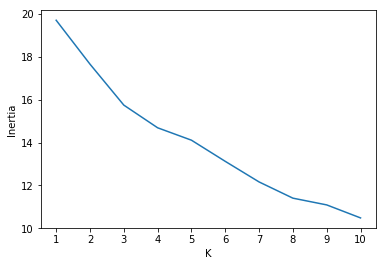

In [163]:
X = venues_in_neighbourhood.drop('Neighbourhood', axis=1)
inertia = [] # sum of squared distances of all points from closest cluster center 
for k in range(1, 11):
    kmeans = KMeans(init = 'k-means++', n_clusters = k, n_init = 20, random_state=0)
    kmeans.fit(X)
    centroids = kmeans.cluster_centers_
    inertia.append(kmeans.inertia_)
    
plt.plot(inertia)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.xticks(range(0, 10), range(1, 11))
plt.show()

We see no clear elbow point in the graph above, so we try the silhoutte method to find optuimum number of clusters. 

Since silhoutte score calcuates dissimilarity we need at least 2 clusters. 

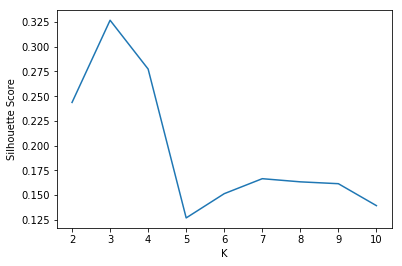

In [125]:
from sklearn.metrics import silhouette_score
sil = []
for k in range(2, 11):
    kmeans = KMeans(init = 'k-means++', n_clusters = k, n_init = 20, random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))

plt.plot(sil)
plt.xticks(range(0, 9), range(2, 11))
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show()

From the silhoutte score, we can see that the best value for k is 3.

In [161]:
k = 3
kmeans = KMeans(init = 'k-means++', n_clusters = k, n_init = 50, random_state=0)
kmeans.fit(X)
labels = kmeans.labels_
X.shape

(96, 272)

Combining venues in neighbourhoods with clusters and assigning cluster labels

In [169]:
# assigning labels as per k-means
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', labels)
toronto_merged = toronto_df

toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Park,Food & Drink Shop,Yoga Studio,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Hockey Arena,Pizza Place,Coffee Shop,Portuguese Restaurant,French Restaurant,Discount Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Pub,Bakery,Park,Theater,Breakfast Spot,Café,Farmers Market,Restaurant,Performing Arts Venue
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Accessories Store,Vietnamese Restaurant,Furniture / Home Store,Sporting Goods Shop,Miscellaneous Shop,Coffee Shop,Boutique,Event Space,Women's Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,Coffee Shop,Diner,Yoga Studio,Burrito Place,Café,Beer Bar,Mexican Restaurant,Bar,Bank,Sushi Restaurant


We check for any neighbourhoods without cluster labels

In [170]:
toronto_merged[toronto_merged['Cluster Labels'].isnull()]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since there are some neighbourhoods with no venues, they did not get assigned to any cluster. Given that this is itself very pecuilar, we can say that these neighbourhoods can themseleves form a cluster.

In [174]:
toronto_merged['Cluster Labels'].fillna(3, inplace=True)

### 8. Cluster Map

In [177]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters and the additional cluster added due to no venues
x = np.arange(k+1)
ys = [i + x + (i*x)**2 for i in range(k+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The map above showcases the various clusters (by color) of neighbourhoods on the basis of similarity of venues nearby. 

### End of Project